In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, concat, avg, udf
from pyspark.sql.types import StructType, StructField, StringType, FloatType

from mpl_toolkits.basemap import Basemap
from geopy.distance import geodesic

import matplotlib.pyplot as plt
import numpy as np

### Create spark session

In [2]:
spark = SparkSession.builder.master("local[1]") \
                    .appName('App') \
                    .getOrCreate()

24/02/09 22:08:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### 1. Load the  dataset into a PySpark DataFrame.

In [3]:
columns_to_load = ["Date", "Time", "Latitude", "Longitude", "Type", "Depth", "Magnitude"]

In [4]:
df = spark.read\
        .format("csv") \
        .option("inferSchema",False) \
        .option("header",True) \
        .option("path","/home/irfan-nunam/aidetic/data/database.csv") \
        .load() \
        .select(columns_to_load)

In [5]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Depth: string (nullable = true)
 |-- Magnitude: string (nullable = true)



In [6]:
df1 = df \
        .withColumn("Time", col("Time").cast(StringType())) \
        .withColumn("Latitude", col("Latitude").cast(FloatType())) \
        .withColumn("Longitude", col("Longitude").cast(FloatType())) \
        .withColumn("Depth", col("Depth").cast(FloatType())) \
        .withColumn("Magnitude", col("Magnitude").cast(FloatType()))

In [7]:
df1.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Longitude: float (nullable = true)
 |-- Type: string (nullable = true)
 |-- Depth: float (nullable = true)
 |-- Magnitude: float (nullable = true)



In [8]:
df1.show(10)

+----------+--------+--------+---------+----------+-----+---------+
|      Date|    Time|Latitude|Longitude|      Type|Depth|Magnitude|
+----------+--------+--------+---------+----------+-----+---------+
|01/02/1965|13:44:18|  19.246|  145.616|Earthquake|131.6|      6.0|
|01/04/1965|11:29:49|   1.863|  127.352|Earthquake| 80.0|      5.8|
|01/05/1965|18:05:58| -20.579| -173.972|Earthquake| 20.0|      6.2|
|01/08/1965|18:49:43| -59.076|  -23.557|Earthquake| 15.0|      5.8|
|01/09/1965|13:32:50|  11.938|  126.427|Earthquake| 15.0|      5.8|
|01/10/1965|13:36:32| -13.405|  166.629|Earthquake| 35.0|      6.7|
|01/12/1965|13:32:25|  27.357|   87.867|Earthquake| 20.0|      5.9|
|01/15/1965|23:17:42| -13.309|  166.212|Earthquake| 35.0|      6.0|
|01/16/1965|11:32:37| -56.452|  -27.043|Earthquake| 95.0|      6.0|
|01/17/1965|10:43:17| -24.563|  178.487|Earthquake|565.0|      5.8|
+----------+--------+--------+---------+----------+-----+---------+
only showing top 10 rows



### 2. Convert the Date and Time columns into a timestamp column named Timestamp

In [9]:
df2 = df1.withColumn("Timestamp", to_timestamp(concat(col("Date"), col("Time")), 'MM/dd/yyyyHH:mm:ss')).drop("Date", "Time")
df2.show(10)

+--------+---------+----------+-----+---------+-------------------+
|Latitude|Longitude|      Type|Depth|Magnitude|          Timestamp|
+--------+---------+----------+-----+---------+-------------------+
|  19.246|  145.616|Earthquake|131.6|      6.0|1965-01-02 13:44:18|
|   1.863|  127.352|Earthquake| 80.0|      5.8|1965-01-04 11:29:49|
| -20.579| -173.972|Earthquake| 20.0|      6.2|1965-01-05 18:05:58|
| -59.076|  -23.557|Earthquake| 15.0|      5.8|1965-01-08 18:49:43|
|  11.938|  126.427|Earthquake| 15.0|      5.8|1965-01-09 13:32:50|
| -13.405|  166.629|Earthquake| 35.0|      6.7|1965-01-10 13:36:32|
|  27.357|   87.867|Earthquake| 20.0|      5.9|1965-01-12 13:32:25|
| -13.309|  166.212|Earthquake| 35.0|      6.0|1965-01-15 23:17:42|
| -56.452|  -27.043|Earthquake| 95.0|      6.0|1965-01-16 11:32:37|
| -24.563|  178.487|Earthquake|565.0|      5.8|1965-01-17 10:43:17|
+--------+---------+----------+-----+---------+-------------------+
only showing top 10 rows



### 3. Filter the dataset to include only earthquakes with a magnitude greater than 5.0.

In [10]:
df3 = df2.filter(df1['Magnitude'] > 5.0)
df3.show(10)

+--------+---------+----------+-----+---------+-------------------+
|Latitude|Longitude|      Type|Depth|Magnitude|          Timestamp|
+--------+---------+----------+-----+---------+-------------------+
|  19.246|  145.616|Earthquake|131.6|      6.0|1965-01-02 13:44:18|
|   1.863|  127.352|Earthquake| 80.0|      5.8|1965-01-04 11:29:49|
| -20.579| -173.972|Earthquake| 20.0|      6.2|1965-01-05 18:05:58|
| -59.076|  -23.557|Earthquake| 15.0|      5.8|1965-01-08 18:49:43|
|  11.938|  126.427|Earthquake| 15.0|      5.8|1965-01-09 13:32:50|
| -13.405|  166.629|Earthquake| 35.0|      6.7|1965-01-10 13:36:32|
|  27.357|   87.867|Earthquake| 20.0|      5.9|1965-01-12 13:32:25|
| -13.309|  166.212|Earthquake| 35.0|      6.0|1965-01-15 23:17:42|
| -56.452|  -27.043|Earthquake| 95.0|      6.0|1965-01-16 11:32:37|
| -24.563|  178.487|Earthquake|565.0|      5.8|1965-01-17 10:43:17|
+--------+---------+----------+-----+---------+-------------------+
only showing top 10 rows



### 4.Calculate the average depth and magnitude of earthquakes for each earthquake type

In [11]:
df4 = df3.groupBy('Type') \
        .agg(
            avg("Depth").alias("Average Depth"), \
            avg("Magnitude").alias("Average Magnitude"), \
        )
df4.show()

+-----------------+------------------+------------------+
|             Type|     Average Depth| Average Magnitude|
+-----------------+------------------+------------------+
|        Explosion|               0.0| 5.849999904632568|
|       Rock Burst|               1.0| 6.199999809265137|
|Nuclear Explosion|0.3000000006811959|5.8506857109069825|
|       Earthquake| 71.31391348824346| 5.882762548783101|
+-----------------+------------------+------------------+



### 5. Implement a UDF to categorize the earthquakes into levels (e.g., Low, Moderate, High) based on their magnitudes

In [12]:
"""
Assumption
----------
Low Level: Magnitude less than 6.0
Moderate Level: Magnitude between 6.0 and 7.0
High Level: Magnitude greater than 7.0
"""

@udf(returnType=StringType())
def categorizeEarthquake(magnitude):
    level = None
    if isinstance(magnitude, float):
        if magnitude < 6.0:
            level =  "Low"
        elif magnitude > 7.0:
            level = "High"
        else:
            level = "Moderate"
    return level

df5 = df3.withColumn("Magnitude Level", categorizeEarthquake(col("Magnitude")))
df5.show(10)

+--------+---------+----------+-----+---------+-------------------+---------------+
|Latitude|Longitude|      Type|Depth|Magnitude|          Timestamp|Magnitude Level|
+--------+---------+----------+-----+---------+-------------------+---------------+
|  19.246|  145.616|Earthquake|131.6|      6.0|1965-01-02 13:44:18|       Moderate|
|   1.863|  127.352|Earthquake| 80.0|      5.8|1965-01-04 11:29:49|            Low|
| -20.579| -173.972|Earthquake| 20.0|      6.2|1965-01-05 18:05:58|       Moderate|
| -59.076|  -23.557|Earthquake| 15.0|      5.8|1965-01-08 18:49:43|            Low|
|  11.938|  126.427|Earthquake| 15.0|      5.8|1965-01-09 13:32:50|            Low|
| -13.405|  166.629|Earthquake| 35.0|      6.7|1965-01-10 13:36:32|       Moderate|
|  27.357|   87.867|Earthquake| 20.0|      5.9|1965-01-12 13:32:25|            Low|
| -13.309|  166.212|Earthquake| 35.0|      6.0|1965-01-15 23:17:42|       Moderate|
| -56.452|  -27.043|Earthquake| 95.0|      6.0|1965-01-16 11:32:37|       Mo

### 6.Calculate the distance of each earthquake from a reference location (e.g., (0, 0)).

In [13]:
@udf(returnType=FloatType())
def getGodesicDistance(latitude, longitude, reference_location = (0,0)):
    if isinstance(latitude, float) and isinstance(longitude, float):
        return geodesic(reference_location, (latitude, longitude)).km
    return None

df6 = df5.withColumn("GodesicDistance(km)", getGodesicDistance(col("Latitude"), col("Longitude")))
df6.show(10)

+--------+---------+----------+-----+---------+-------------------+---------------+-------------------+
|Latitude|Longitude|      Type|Depth|Magnitude|          Timestamp|Magnitude Level|GodesicDistance(km)|
+--------+---------+----------+-----+---------+-------------------+---------------+-------------------+
|  19.246|  145.616|Earthquake|131.6|      6.0|1965-01-02 13:44:18|       Moderate|          15713.401|
|   1.863|  127.352|Earthquake| 80.0|      5.8|1965-01-04 11:29:49|            Low|          14174.173|
| -20.579| -173.972|Earthquake| 20.0|      6.2|1965-01-05 18:05:58|       Moderate|          17637.125|
| -59.076|  -23.557|Earthquake| 15.0|      5.8|1965-01-08 18:49:43|            Low|           6866.697|
|  11.938|  126.427|Earthquake| 15.0|      5.8|1965-01-09 13:32:50|            Low|          13972.041|
| -13.405|  166.629|Earthquake| 35.0|      6.7|1965-01-10 13:36:32|       Moderate|          17928.916|
|  27.357|   87.867|Earthquake| 20.0|      5.9|1965-01-12 13:32:

### 7.Visualize the geographical distribution of earthquakes on a world map using appropriate libraries

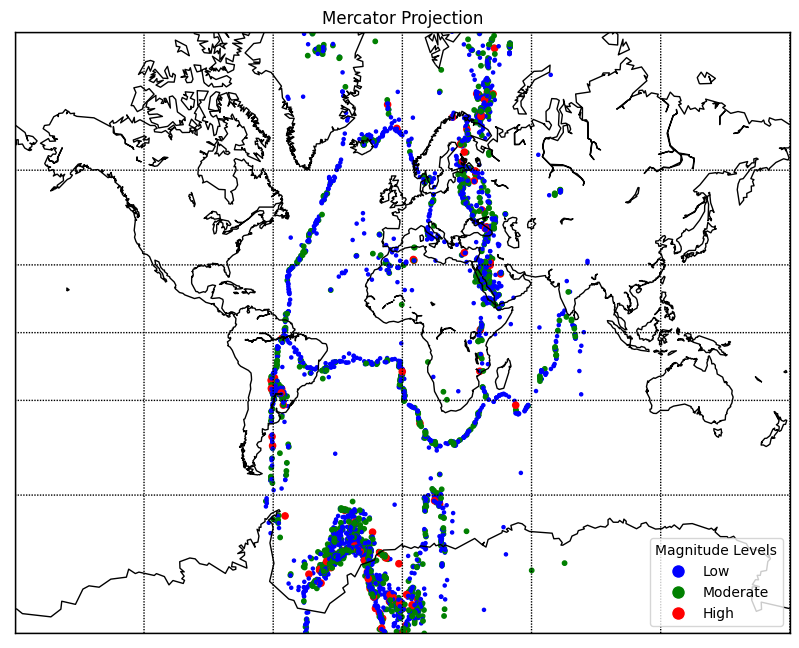

In [14]:
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'c' means use crude resolution coastlines.
plt.figure(figsize=(10, 8)) 
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary() 

# Map magnitude levels to colors and sizes
color_mapping = {"Low": "blue", "Moderate": "green", "High": "red"}
size_mapping = {"Low": 5, "Moderate": 10, "High": 20}

magnitude_levels = [row['Magnitude Level'] for row in df5.select('Magnitude Level').collect()]
lons = [float(row['Latitude']) for row in df5.select('Latitude').collect()]
lats = [float(row['Longitude']) for row in df5.select('Longitude').collect()]
colors = [color_mapping[level] for level in magnitude_levels]
sizes = [size_mapping[level] for level in magnitude_levels]

x, y = m(lons, lats)

m.scatter(x, y, marker='o',color=colors, s=sizes)

# Create legend
legend_labels = list(color_mapping.keys())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10, label=label) for label in legend_labels]

plt.legend(handles=legend_handles, loc='lower right', title='Magnitude Levels')
plt.title("Mercator Projection")
plt.show()